# Homework 4: SVM


This assignment is due on Moodle by **11:59pm on Friday November 8**. 
Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.
Your solutions to computational questions should include any specified Python code and results 
as well as written commentary on your conclusions.
Remember that you are encouraged to discuss the problems with your instructors and classmates, 
but **you must write all code and solutions on your own**. For a refresher on the course **Collaboration Policy** click [here](https://github.com/BoulderDS/CSCI5622-Machine-Learning/blob/master/info/syllabus.md#collaboration-policy).

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda (Version: 2019.07) with Python 3.7. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 
- In this homework you will explore the primal and dual representations of support vector machines, as well as the performance of various kernels while classifying sentiments. Install the following packages: `nltk` (Version: 3.4.5), `scikit-learn` (Version: 0.21.3)


Name: 

In [2]:
import math
import pickle
import gzip
import numpy as np
import pandas
import matplotlib.pylab as plt
%matplotlib inline

[40 Points] Problem 1 - Basic concepts of SVM
---

**Part 1 [10 points]:** 
* What are the main differences between the primal and the dual representations?
* For the variables $\xi_i$, $C$ in the primal formation, what are their roles? Write out the upper/lower bounds (constraints) of these variables. What are the interpretation for these maximum/minimum values?
* For the variable $\alpha_i$, $\beta_i$ in the dual formation, what are the upper/lower bound (constraints) of them?

YOUR ANSWER HERE

***1.Main differences between the primal and dual representations***

(a) Solving the primal problem, we obtain the optimal 𝑤, but know nothing about the $\alpha_i$. In order to classify a query point 𝑥 we need to explicitly compute the scalar product $𝑤^𝑇𝑥$, which may be expensive if 𝑑 is large. Solving the dual problem, we obtain the $\alpha_i$ (where $\alpha_i$=0 for all but a few points - the support vectors).

(b) By examining the dual form of the optimization problem, we gained significant insight into the structure of the problem, and were also able to write the entire algorithm in terms of only inner products between input feature vectors.

(c) In primal representation, we optimize

$\min_{w,b}=\frac{1}{2} \Vert{w}\Vert^2$ 

subject to $y_i(w.x_i+b)\ge1 , i\in[1,m]$. 

In dual representation, we optimize

$ \max_\alpha \sum_{i=1}^m \alpha_i -\frac{1}{2} \sum_{i=1}^m\sum_{j=1}^m\alpha_i \alpha_j y_i y_j(x_j . x_i)$

subject to $\alpha_i \ge 0, i\in[1,m], \sum_{i} \alpha_i y_i =0$

(d) In dual representation, the constraints become simplified and the main objective is to find the $\alpha$ values.

***2. About*** $\xi_i, C$ ***values in primal formation***

(a) $\xi_i$ defines slack variables i.e. how wrong a point is. $\xi_i$ is always $\ge 0$. The values of $\xi_i$ are as follows.

$\xi_i$ = 0, if $y_i(w.x_i+b)\ge 1$ i.e. satisfies the margin.

$\xi_i$ = $1-y_i(w.x_i+b)$, Otherwise i.e. does not satisfy the margin.

These bounds could be interpreted as when a point $x_i$ lies within or on the margin, there is no need of a slack variable. Hence, $\xi_i$ becomes 0. On the other hand, $\xi_i$ becomes $1-y_i(w.x_i+b)$ when the point $x_i$ does not satisfy the margin and lies in the opposite side.

(b) $C$ defines the trade-off between margin and slack variables. $C$ is always $\ge 0$. As $C$ increases, the margin increases. This in turn decreases overfitting, decreases the bias and increases the variance.

***3. About*** $\alpha_i, \beta_i$ ***values in dual formation***

(a) $\alpha_i$ is always $\ge 0$. It is non-zero for the support vectors and zero for the remaining vectors that do not contribute to the weight w. In soft-margin SVM, the bounds of $\alpha_i$ are $C\ge\alpha_i\ge0$.

(b) $\beta_i$ is always $\ge 0$. In soft-margin SVM, the bounds of $\beta_i$ are $C\ge\beta_i\ge0$. $\alpha_i$ and $\beta_i$ are related such that $\alpha_i+\beta_i=C$. Therefore, when $\alpha_i=0$, $\beta_i=C$ and when $\alpha_i=C$, $\beta_i=0$. Also, $\alpha_i$ and $\xi_i$ are related such that $\beta_i \xi_i=0$. Therefore, either $\xi_i=0$ or $\beta_i=0$.

**Part 2 [20 points]:** 

 * Given a weight vector, implement the `find_support` function that returns the indices of the support vectors.
 * Given a weight vector, implement the `find_slack` function that returns the indices of the vectors with nonzero slack.
 * Given the alpha dual vector, implement the `weight_vector` function that returns the corresponding weight vector.

In [4]:
class SVM:
    
    def __init__(self):
        self.kINSP = np.array([(1, 8, +1),
                       (7, 2, -1), 
                       (6, -1, -1),
                       (-5, 0, +1),
                       (-5, 1, -1),
                       (-5, 2, +1),
                       (6, 3, +1),
                       (6, 1, -1),
                       (5, 2, -1)])
        self.kSEP = np.array([(-2, 2, +1),    # 0 - A
                      (0, 4, +1),             # 1 - B
                      (2, 1, +1),             # 2 - C
                      (-2, -3, -1),           # 3 - D
                      (0, -1, -1),            # 4 - E
                      (2, -3, -1),            # 5 - F
                      ])


    def weight_vector(self, x, y, alpha):
        """
        Given a vector of alphas, compute the primal weight vector w.
        The vector w should be returned as an Numpy array.
        """
        w = np.zeros(len(x[0]))
        # YOUR CODE HERE
        i=0
        while(i<len(x[0])):
            for j in range(len(x)):
                w[i]+=x[j][i]*y[j]*alpha[j]
            i+=1
        #raise NotImplementedError()
        return w



    def find_support(self, x, y, w, b, tolerance=0.001):
        """
        Given a set of training examples and primal weights, return the indices
        of all of the support vectors as a set.
        """
        support = set()
        # YOUR CODE HERE
        #support vectors lie on the margin y(wx+b)=1
        for i in range(len(x)):
            if y[i]*(x[i].dot(w)+b)<=1+tolerance and y[i]*(x[i].dot(w)+b)>=1-tolerance:
                support.add(i)
        #raise NotImplementedError()
        return support



    def find_slack(self, x, y, w, b):
        """
        Given a set of training examples and primal weights, return the indices
        of all examples with nonzero slack as a set.
        """
        slack = set()
        # YOUR CODE HERE
        #nonzero slack only when x does not satisfy the margin
        for i in range(len(x)):
            if y[i]*(x[i].dot(w)+b)<1:
                slack.add(i)
        #raise NotImplementedError()
        return slack

In [5]:
from tests import tests
tests.run_test_suite("prob 1", SVM)

TestWideSlack (tests.tests.TestSVM) ... ok
TestNarrowSlack (tests.tests.TestSVM) ... ok
TestSupport (tests.tests.TestSVM) ... ok
TestWeight (tests.tests.TestSVM) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


**Part 3 [10 points]:** 

The goal of this problem is to correctly classify test data points, given a training data set.
For this problem, assume that we are training an SVM with a quadratic kernel, which means our kernel function is a polynomial kernel of degree 2. You are given the data set presented in the figure below. The slack penalty $C$ will determine the location of the decision boundary.

Justify the following questions in a sentence or via drawing decision boundary.
![training_data](./data/data.png)

* Where would the decision boundary be for very large values of $C$ ?
* Where you would expect the decision boundary to be if  $C = 0$ ?
* Which of the two cases above would you expect to generalize better on test data? Why?

YOUR ANSWER HERE

***1.Decision boundary for very large values of C***

This decision boundary lies very close to one of the classes and aims at exactly dividing the positive and negative class points with no misclassification. Also, The margin is no longer maximized.

***2.Decision boundary for C=0***

This decision boundary would be in the middle, with 2 misclassification of the red points. When C=0, $\xi_i$ can take large values and Hence, the margin is maximized.

***3.Case 2 generalizes better on test data***

This is because case 1 results in overfitting on the train data and the margin is not maximized. That is, it gives high training accuracy, but low testing accuracy. On the other hand, case 2 allows certain misclassifications and maximizes the margin which is the ultimate goal of a support vector machine.

[30 points] Problem 2 - The Kernel Trick
---
The kernel trick can make SVM powerful and become non-linear. In this problem we will get familiar with the kernel trick.

**Part 1 [10 points]:**

We will construct a support vector machine that computes the XOR function, using values of +1 and −1 (instead of 1 and 0) for both inputs and outputs, so that an example looks like ($[−1, 1], 1$) or ($[−1, −1], −1$). Map the input $[x_1, x_2]$ into a space consisting of $x_1$ and $x_1x_2$. Plot the four input points in this space, and the maximal margin separator. Give the margin value in the markdown cell. Remeber to indicate which points have output +1 and which -1.

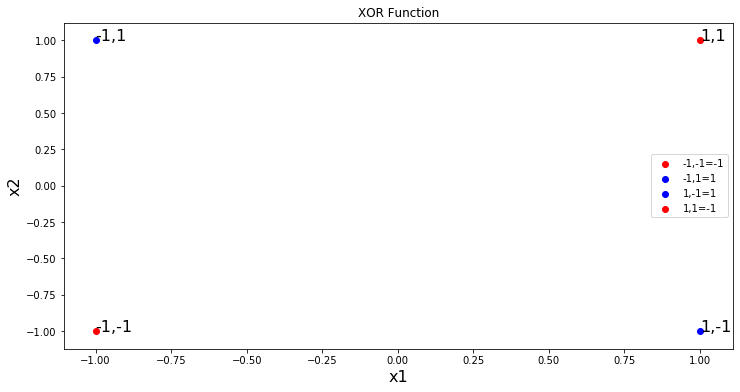

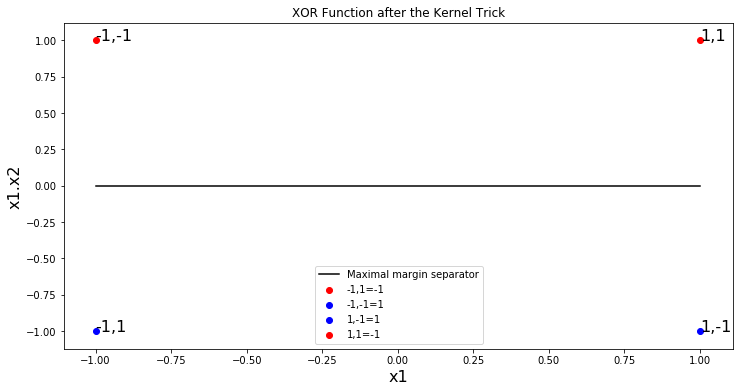

In [5]:
# YOUR CODE HERE
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
fig1, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax1.title.set_text("XOR Function")
ax1.set_xlabel("x1", fontsize=16)
ax1.set_ylabel("x2", fontsize=16)
ax2.title.set_text("XOR Function after the Kernel Trick")
ax2.set_xlabel("x1", fontsize=16)
ax2.set_ylabel("x1.x2", fontsize=16)
color={1:'blue',-1:'red'}
x1=[-1,-1,1,1]
x2=[-1,1,-1,1]
y=[-1,1,1,-1]
for i in range(len(y)):
    ax1.scatter(x1[i],x2[i],color=color[y[i]],label=str(x1[i])+","+str(x2[i])+"="+str(y[i]))
    ax1.text(x1[i],x2[i],str(x1[i])+","+str(x2[i]), fontsize=16)
    ax2.scatter(x1[i],x1[i]*x2[i],color=color[y[i]],label=str(x1[i])+","+str(x1[i]*x2[i])+"="+str(y[i]))
    ax2.text(x1[i],x2[i],str(x1[i])+","+str(x1[i]*x2[i]), fontsize=16)
ax2.plot(x1,np.linspace(0,0,4),color='black',label="Maximal margin separator")
ax1.legend()
ax2.legend()
#raise NotImplementedError()

YOUR ANSWER HERE

The Margins exist at $x_1x_2=1$ and  $x_1x_2=-1$. The Maximal margin separator is at $x_1x_2=0$.

**Part 2 [5 points]:** Plot the separating line of **Part 1** back in the original Euclidean input space.

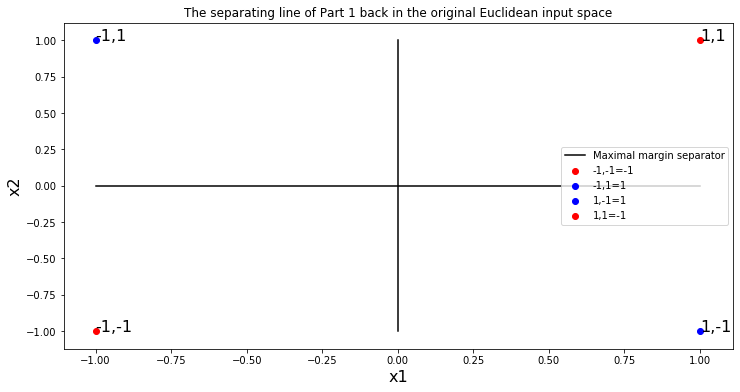

In [6]:
# YOUR CODE HERE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.set_xlabel("x1", fontsize=16)
ax.set_ylabel("x2", fontsize=16)
ax.title.set_text("The separating line of Part 1 back in the original Euclidean input space")
for i in range(len(y)):
    ax.scatter(x1[i],x2[i],color=color[y[i]],label=str(x1[i])+","+str(x2[i])+"="+str(y[i]))
    ax.text(x1[i],x2[i],str(x1[i])+","+str(x2[i]), fontsize=16)
ax.plot(np.linspace(-1,1,100),[0]*100,color="black",label="Maximal margin separator")
ax.plot([0]*100,np.linspace(-1,1,100),color="black")
ax.legend(loc='center right')
#raise NotImplementedError()

**Part 3 [5 points]:** Is the seporater in **Part 1** linear? Is the one in **Part 2** linear? Explain your answer.

YOUR ANSWER HERE

The separator in Part 1 is linear while the one in Part 2 is non-linear. This is because the line $x_1x_2=0$ is linear in Part 2 where the y-axis denotes $x_1x_2$. When this separator is plotted back in the original Euclidean input space, $x_1x_2=0$ when either $x_1=0$ or $x_2=0$ or both $x_1$ and $x_2$ are equal to zero. This forms a non-linear hyperplane separating the y=-1 points from the y=+1 points. This shows that the Kernel trick can be used to classify data that are not linearly separable.

**Part 4 [10 points]:**
The key point of the so-called “kernel trick” in SVMs is to learn a classifier that effectively separates the training data in a higher dimensional space without having to explicitly compute the representation $\phi(\mathbf{x})$ of every point $\mathbf{x}$ in the original input space. Instead, all the work is done through the kernel function $K(\mathbf{x}_i, \mathbf{x}_i)$, for example, we can use $K(\mathbf{x}_i, \mathbf{x}_i) = \phi(\mathbf{x}_i)\phi(\mathbf{x}_j)$.

Show how to compute the squared Euclidean distance in the projected space between any two points $\mathbf{x}_i$, $\mathbf{x}_j$ in the original space without explicitly computing the $\phi$ mapping, instead using the kernel function $K$. In other words, derive $d(\phi(\mathbf{x}_i), \phi(\mathbf{x}_j))$ into a form using only the kernel function.

YOUR ANSWER HERE

$d(\phi(\mathbf{x}_i), \phi(\mathbf{x}_j)) = (\phi(\mathbf{x}_i) - \phi(\mathbf{x}_j))^2$

$= (\phi(\mathbf{x}_i))^2 + (\phi(\mathbf{x}_j)^2 - 2 (\phi(\mathbf{x}_i) (\phi(\mathbf{x}_j))$

$=((\phi(\mathbf{x}_i)(\phi(\mathbf{x}_i)) + ((\phi(\mathbf{x}_j)(\phi(\mathbf{x}_j)) -2 K(\mathbf{x}_i, \mathbf{x}_j)$

$=K(\mathbf{x}_i, \mathbf{x}_i) + K(\mathbf{x}_j, \mathbf{x}_j) -2 K(\mathbf{x}_i, \mathbf{x}_j)$

Therefore, $d(\phi(\mathbf{x}_i), \phi(\mathbf{x}_j))$ can be derived only in terms of the kernel function without explicitly computing the $\phi$ mapping for every point x.

[30 points] Problem 3 - SVM with `sklearn`
---

In this problem, you will get familiar with important practical functions in scikit-learn such as pipeline, grid search, and cross validation. You will experiment with these using support vector machines.

Note that grid search can take some time on your laptop, so make sure that your code is correct with a small subset of the training data and search a reasonable number of options.

* Use the Sklearn implementation of support vector machines to train a classifier to distinguish Positive and negative sentiments
* Experiment with linear, polynomial, and RBF kernels. First, perform a GridSearch over each kernel function and a small set of parameters defined over a wide range to help narrow down the search space.
* Then choose the best performing kernel from your coarse scale search and define a narrower set of parameters for random search to further optimize the hyperparameters. Comment on the experiments you ran and optimal hyperparameters you found.
Hint: http://scikit-learn.org/stable/modules/grid_search.html
* Evaluate classification performance for each model for optimal parameters by testing on a hold-out set.

Following is a dataset containing reviews and sentiments associated with it.

We will create a SVM Classifier to predict positive or negative sentiments.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
reviews  = pd.read_csv('./data/reviews.csv')
train, test = train_test_split(reviews, test_size=0.2, random_state=5622)
X_train = train['reviews']
X_test = test['reviews']
y_train = train['sentiment']
y_test = test['sentiment']

In [9]:
len(X_train),sum(y_train),len(X_test),sum(y_test)

(4000, 1995, 1000, 505)

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

**Part 1 [5 points]:**

Use `CountVectorizer` to vectorize reviews as dictionary of term frequencies.
Define the crossvalidation split using `StratifiedKFold`.

In [11]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

nltk.download('stopwords')
en_stopwords = set(stopwords.words("english")) 

# CREATE CountVectorizer using sklearn.feature_extraction.text.CountVectorizer
# Hint: use the above tokenize function
# Hint: play with different parameters, in particular, min_df can help with generalizability
# YOUR CODE HERE
cv=CountVectorizer(tokenizer=tokenize,stop_words=en_stopwords,min_df=1)
cv.fit(X_train)
#raise NotImplementedError()

# split dataset using StratifiedKFold into 5 splits using sklearn.model_selection.StratifiedKFold.
# YOUR CODE HERE
kfolds = StratifiedKFold(n_splits=5)
kfolds.get_n_splits(X_train,y_train)
#raise NotImplementedError()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swarnalathanatarajan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


5

**Part 2 [10 points]:**
* Create a pipeline with our `CountVectorizer` object in **Part 1** and an SVM Classifier.
* Create and fit a `GridSearchCV` object with the following parameter values:
  * Linear kernel, $C = 0.01, 1.0, 10.0$
  * Polynomial kernel, $\text{degree} = 2, 3$, $\gamma = 0.1, 0.5, 1$
  * RBF kernel, $\gamma = 0.1, 0.5, 1$
* Report accuracy on the best estimator from our `GridSearchCV` object.

In [12]:
np.random.seed(5622)
# Define pipeline using make_pipeline with vectorizer and SVM Classifier
# YOUR CODE HERE
pipeline_svm = make_pipeline(cv,SVC())
#raise NotImplementedError()

# Create GridSearchCV with pipeline and the grid search parameters given above,
# using "accuracy" for scoring.

# YOUR CODE HERE
tuned_parameters = [{'svc__kernel': ['linear'], 'svc__C': [0.01,1, 10]},
                    {'svc__kernel': ['poly'],'svc__degree':[2,3],'svc__gamma': [0.1,0.5, 1]},
                    {'svc__kernel': ['rbf'], 'svc__gamma': [0.1,0.5, 1]}]
grid_svm = GridSearchCV(pipeline_svm,tuned_parameters, cv=kfolds,scoring='accuracy',iid=True)
#raise NotImplementedError()

# For debugging purposes, it makes sense to use a smaller set of training set to speed up the grid search progress
_ = grid_svm.fit(X_train, y_train)

In [13]:
# Report best parameters and CV score from grid search
# YOUR CODE HERE
print(grid_svm.best_params_,grid_svm.best_score_)
#raise NotImplementedError()

{'svc__C': 0.01, 'svc__kernel': 'linear'} 0.87425


**Part 3 [10 points]:**

Choose the best performing kernel and parameter values from your coarse scale grid search and use them to set up a narrower range of parameter values. We will use randomized grid search to sample a fixed number of these candidate parameter sets for cross validation. The number of sampled parameter sets `n_iter` provides a trade-off between computational cost and quality of the "optimal" parameters. Feel free to experiment with different values of this parameter, but please change it back to `n_iter = 5` before submitting your assignment.

In [14]:
# Set random seed for deterministic output
np.random.seed(5622)

# Set param_grid to a dictionary containing parameter values for fine scale search.
# YOUR CODE HERE
kernel=grid_svm.best_params_['svc__kernel']
if kernel=='linear':
    C=grid_svm.best_params_['svc__C']
    param_grid={'svc__kernel':[kernel],'svc__C': np.arange(0,C,C/1000).tolist()}
elif kernel=='poly':
    gamma=grid_svm.best_params_['svc__gamma']
    param_grid={'svc__kernel':[kernel],'svc__gamma':[gamma/4,gamma/2,gamma],'svc__degree':[grid_svm.best_params_['svc__degree']]}
else:
    gamma=grid_svm.best_params_['svc__gamma']
    param_grid={'svc__kernel':[kernel],'svc__gamma':[gamma/4,gamma/2,gamma]}                
#raise NotImplementedError()

# Create randomized parameter search over fine scale grid;
# Do NOT change the value of n_iter in the submitted version of your notebook.
n_iter = 5
random_svm = RandomizedSearchCV(pipeline_svm,
                                param_grid,
                                n_iter=n_iter,
                                cv = kfolds,
                                scoring="accuracy",
                                verbose=1,   
                                n_jobs=-1)

_ = random_svm.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   33.8s finished


In [15]:
# Report best parameters and CV score from grid search
# YOUR CODE HERE
print(random_svm.best_params_,random_svm.best_score_)
#raise NotImplementedError()

{'svc__kernel': 'linear', 'svc__C': 0.006180000000000001} 0.87475


In [16]:
def report_results(model, X, y):
    pred = model.predict(X)        
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [17]:
report_results(random_svm.best_estimator_, X_test, y_test)

{'f1': 0.8823529411764707,
 'acc': 0.88,
 'precision': 0.8737864077669902,
 'recall': 0.8910891089108911}

**Part 4 [5 points]:**

Explain the overall procedure, and report the final result including which hyperparameter values were chosen. Make sure to explain your reasoning in choosing a refined parameter search space in **Part 3**.

YOUR ANSWER HERE
1. The reviews and sentiments are read from the csv file and stored in X_train, X_test, y_train and y_test respectively.

2. The CountVectorizer creates a dictionary with words in the X_train as keys and their respective frequency as the value. The custom tokenizer and stop words parameters are also set.

3. StratifiedKFold is performed to split the data into 5 splits with equal class samples in each of the splits.

4. A pipeline is created which comprises of the count vectorizer object and SVC().

5. Grid search is performed for the given kernel types and parameters. The best parameter is determined. ***The best parameters were kernel : linear, C=0.01 with CV score=0.87425***.

6. Now, Randomized search was performed for a refined parameter search space of the best parameter kernel='linear' for larger set of possible C values. ***This resulted in an updated best C value = 0.006180000000000001 with increased CV score=0.87475***.

7. On testing the model, an accuracy of 88% was achieved.

### Optional survey.
***

We are always interested in your feedback. At the end of each homework, there is a simple anonymous feedback [survey](https://forms.gle/bEaNM6G2qFRKhU4Z9) to solicit your feedback for how to improve the course.